In [1]:
#import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import re

## Load Data

In [2]:
# Cấu hình hiển thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Đường dẫn file tổng (sau khi đã gộp ở bước trên)
DATA_PATH = "../data/03_primary/final_labeled_dataset.json"

# Load dữ liệu
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f"Tổng số bài đăng (Documents): {len(raw_data)}")

Tổng số bài đăng (Documents): 1139


In [13]:
def parse_label_studio_data(data):
    stats = {
        "ner_labels": [],       # Danh sách tất cả nhãn NER
        "re_relations": [],     # Danh sách tất cả quan hệ
        "doc_lengths": [],      # Độ dài văn bản (số ký tự)
        "entities_per_doc": [], # Số thực thể trong 1 bài
        "relations_per_doc": [] # Số quan hệ trong 1 bài
    }
    
    for task in data:
        # Lấy text gốc
        text = task['data']['text']
        stats['doc_lengths'].append(len(text))
        
        # Lấy annotations
        if not task.get('annotations'): continue
        result = task['annotations'][0]['result']
        
        ent_count = 0
        rel_count = 0
        
        for item in result:
            if item['type'] == 'labels':
                if 'value' in item and 'labels' in item['value']:
                    label = item['value']['labels'][0]
                    stats['ner_labels'].append(label)
                    ent_count += 1
                
            elif item['type'] == 'relation':
                if 'labels' in item:
                    relation = item['labels'][0]
                    stats['re_relations'].append(relation)
                    rel_count += 1
        
        stats['entities_per_doc'].append(ent_count)
        stats['relations_per_doc'].append(rel_count)
        
    return stats

parsed_stats = parse_label_studio_data(raw_data)
print("Data parsing completed")

print(f"Tổng số nhãn NER: {len(parsed_stats['ner_labels'])}")
print(f"Tổng số quan hệ RE: {len(parsed_stats['re_relations'])}")
print(f"Tổng số độ dài văn bản: {len(parsed_stats['doc_lengths'])}")
print(f"Tổng số thực thể trên mỗi bài: {len(parsed_stats['entities_per_doc'])}")
print(f"Tổng số quan hệ trên mỗi bài: {len(parsed_stats['relations_per_doc'])}")

Data parsing completed
Tổng số nhãn NER: 19023
Tổng số quan hệ RE: 14826
Tổng số độ dài văn bản: 1139
Tổng số thực thể trên mỗi bài: 1139
Tổng số quan hệ trên mỗi bài: 1139


**Thống kê và Vẽ biểu đồ NER**

In [16]:
ner_counts = Counter(parsed_stats['ner_labels'])
df_ner = pd.DataFrame.from_dict(ner_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)

print("--- THỐNG KÊ NER ---")
df_ner

--- THỐNG KÊ NER ---


,Count
ATTR,7863
LOC,3947
AREA,2731
TYPE,1808
PRICE,1595
O,512
PER,371
ORG,196


C:\Users\LEGION\AppData\Local\Temp\ipykernel_3180\1275889554.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ner.index, y=df_ner['Count'], palette="viridis")


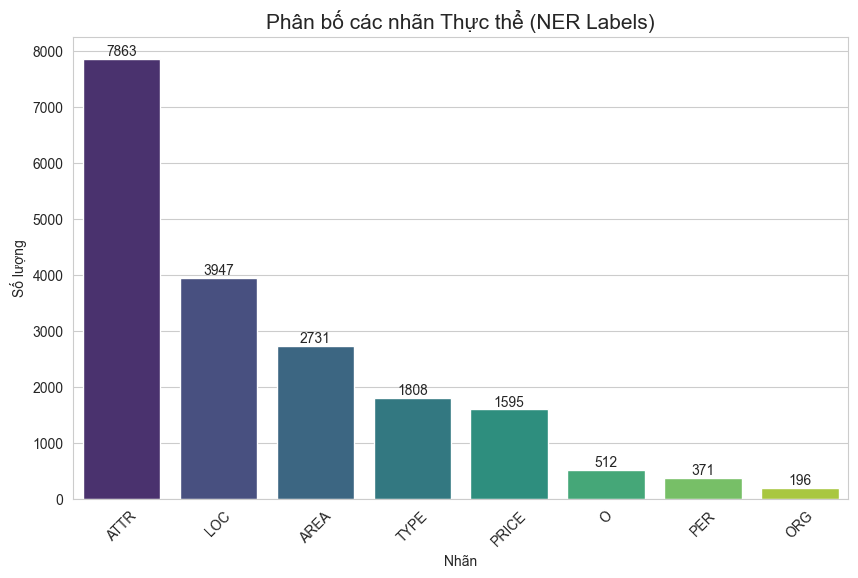

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_ner.index, y=df_ner['Count'], palette="viridis")
plt.title("Phân bố các nhãn Thực thể (NER Labels)", fontsize=15)
plt.xlabel("Nhãn")
plt.ylabel("Số lượng")
plt.xticks(rotation=45)
for i, v in enumerate(df_ner['Count']):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

**Thống kê và Vẽ biểu đồ RE**

In [18]:
re_counts = Counter(parsed_stats['re_relations'])
df_re = pd.DataFrame.from_dict(re_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)

print("--- Thống kê RE ---")
df_re

--- Thống kê RE ---


,Count
HAS_ATTR,8115
LOCATED_AT,2872
HAS_AREA,2426
HAS_PRICE,1413


C:\Users\LEGION\AppData\Local\Temp\ipykernel_3180\2098098456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_re.index, y=df_re['Count'], palette="magma")


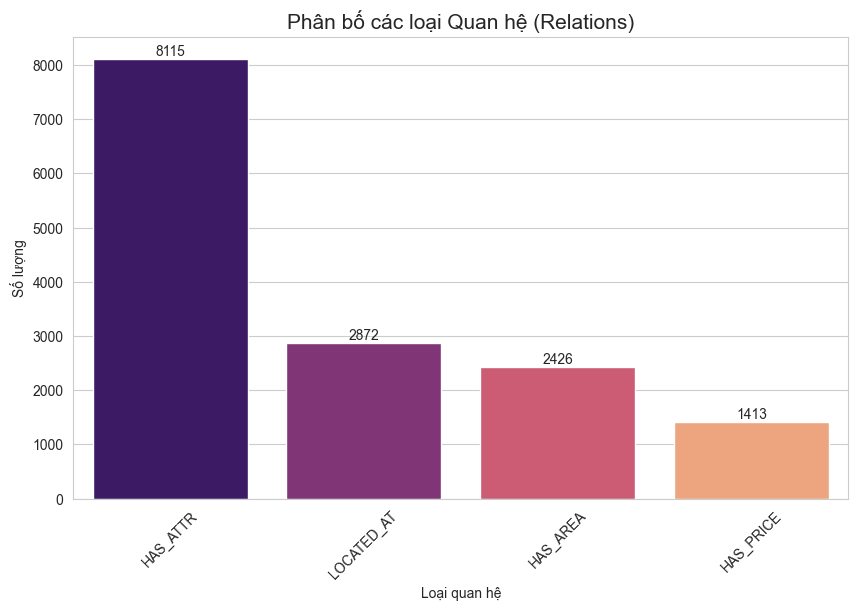

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_re.index, y=df_re['Count'], palette="magma")
plt.title("Phân bố các loại Quan hệ (Relations)", fontsize=15)
plt.xlabel("Loại quan hệ")
plt.ylabel("Số lượng")
plt.xticks(rotation=45)
for i, v in enumerate(df_re['Count']):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.show()

**Phân tích Độ dài câu và Mật độ thông tin**

In [25]:
df_stats = pd.DataFrame({
    'Length': parsed_stats['doc_lengths'],
    'Entities': parsed_stats['entities_per_doc'],
    'Relations': parsed_stats['relations_per_doc']
})

print("--- THỐNG KÊ MÔ TẢ ---")
df_stats.describe()

--- THỐNG KÊ MÔ TẢ ---


,Length,Entities,Relations
count,1139.000000,1139.000000,1139.000000
mean,472.449517,16.701493,13.016681
std,371.618760,9.770949,7.394880
min,36.000000,0.000000,0.000000
25%,228.500000,10.000000,8.000000
50%,353.000000,14.000000,12.000000
75%,606.500000,20.000000,17.000000
max,2687.000000,98.000000,67.000000


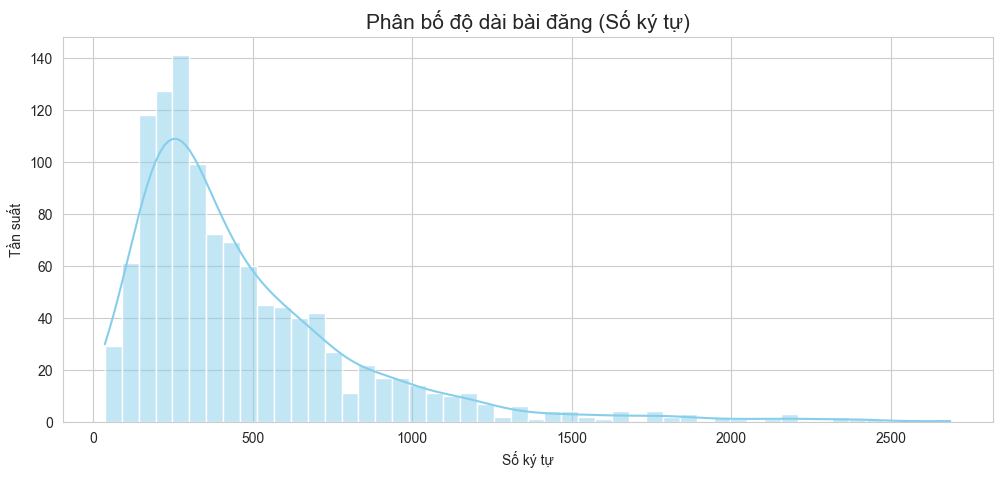

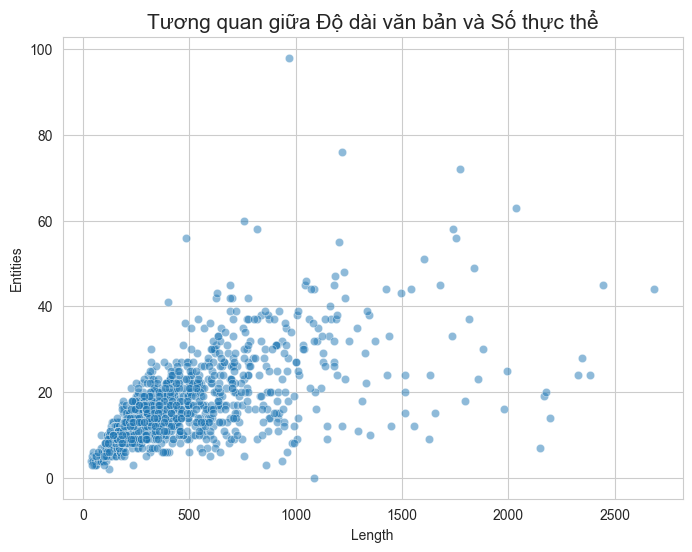

In [22]:
plt.figure(figsize=(12, 5))
sns.histplot(df_stats['Length'], bins=50, kde=True, color='skyblue')
plt.title("Phân bố độ dài bài đăng (Số ký tự)", fontsize=15)
plt.xlabel("Số ký tự")
plt.ylabel("Tần suất")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_stats, x='Length', y='Entities', alpha=0.5)
plt.title("Tương quan giữa Độ dài văn bản và Số thực thể", fontsize=15)
plt.show()